[INFO] Using format CF32.
OOOO

Failed to read samples from SDR
Failed to read samples from SDR
Failed to read samples from SDR
Failed to read samples from SDR
Failed to read samples from SDR
Failed to read samples from SDR


OOOOO

Failed to read samples from SDR
Failed to read samples from SDR
Failed to read samples from SDR
Failed to read samples from SDR
Failed to read samples from SDR


OO

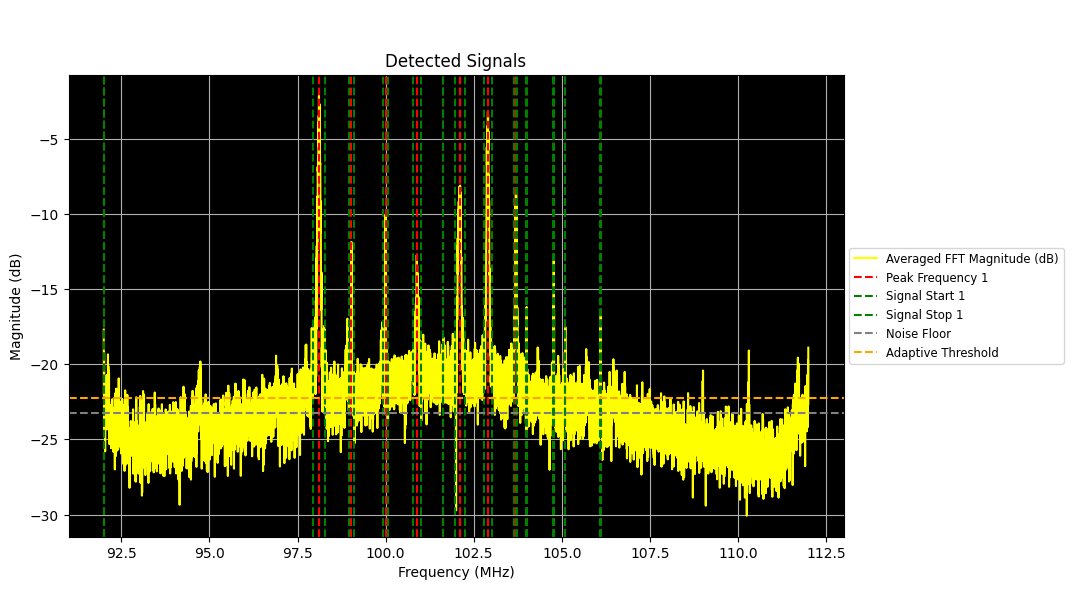

Peak Frequency (MHz) Bandwidth (MHz)     
92.00                0.00                


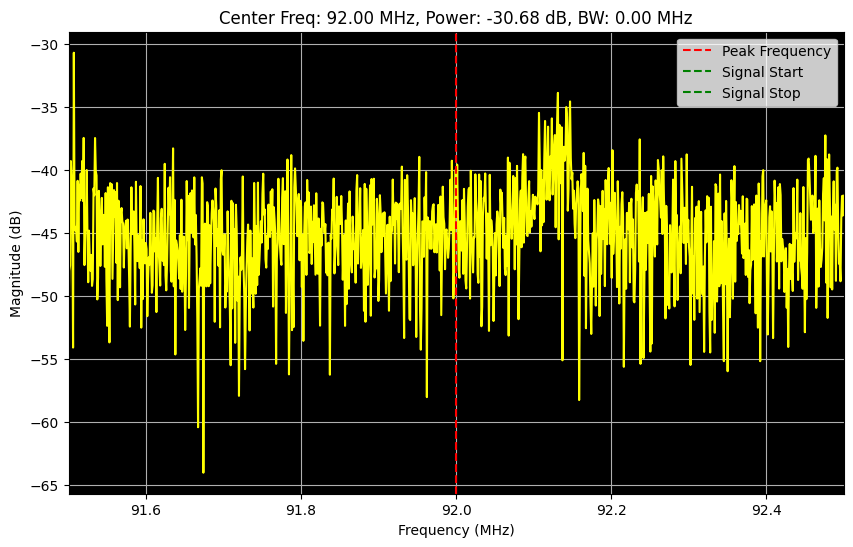

Refined Bandwidth: 0.00 MHz
98.11                0.36                


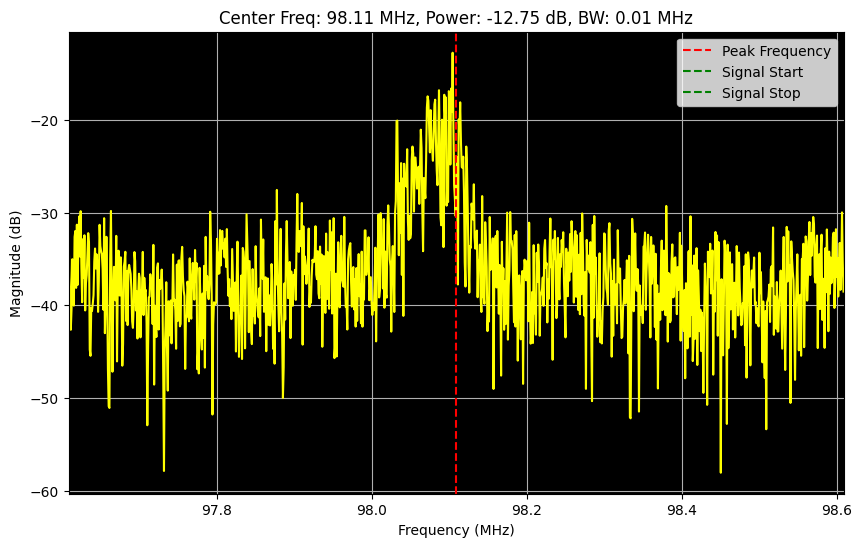

Refined Bandwidth: 0.01 MHz
99.03                0.12                


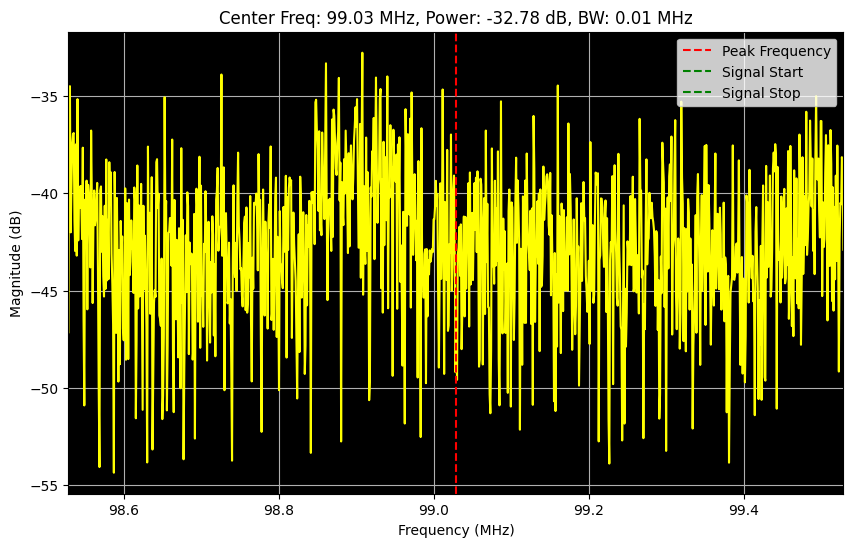

Refined Bandwidth: 0.01 MHz
100.00               0.13                


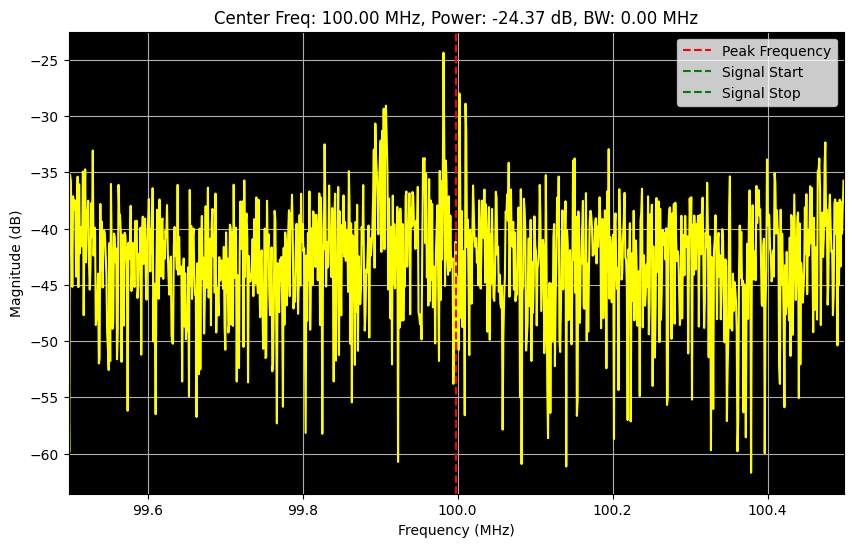

Refined Bandwidth: 0.00 MHz
100.88               0.22                


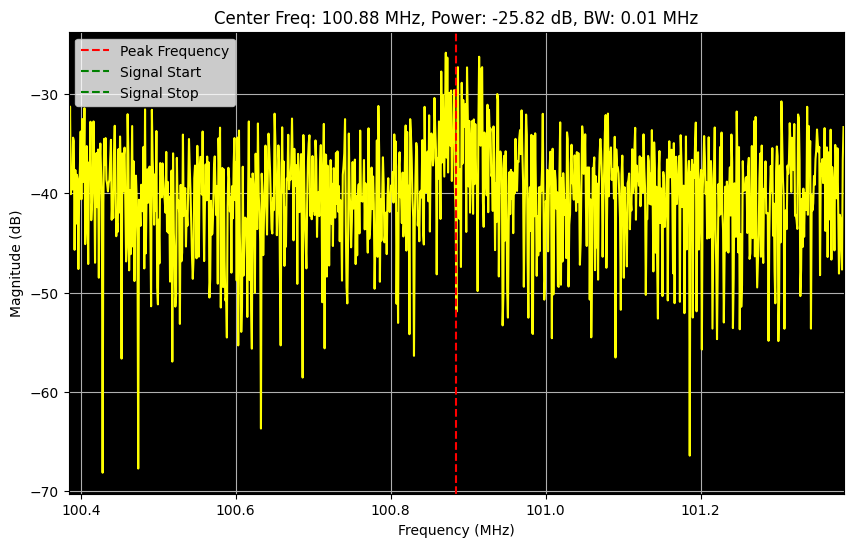

Refined Bandwidth: 0.01 MHz
101.64               0.00                


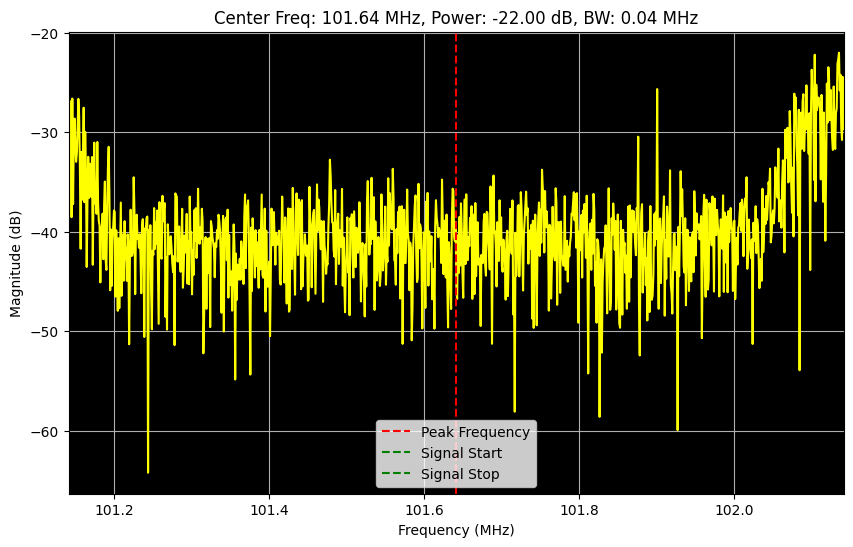

Refined Bandwidth: 0.04 MHz
102.11               0.30                


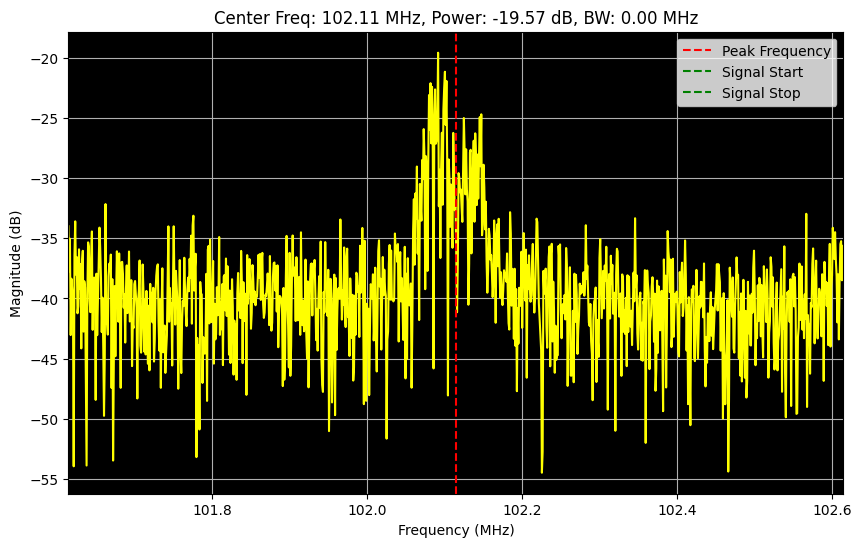

Refined Bandwidth: 0.00 MHz
102.90               0.24                
Failed to read samples from SDR


[WARNING] Read Timeout occured after 100000 ms


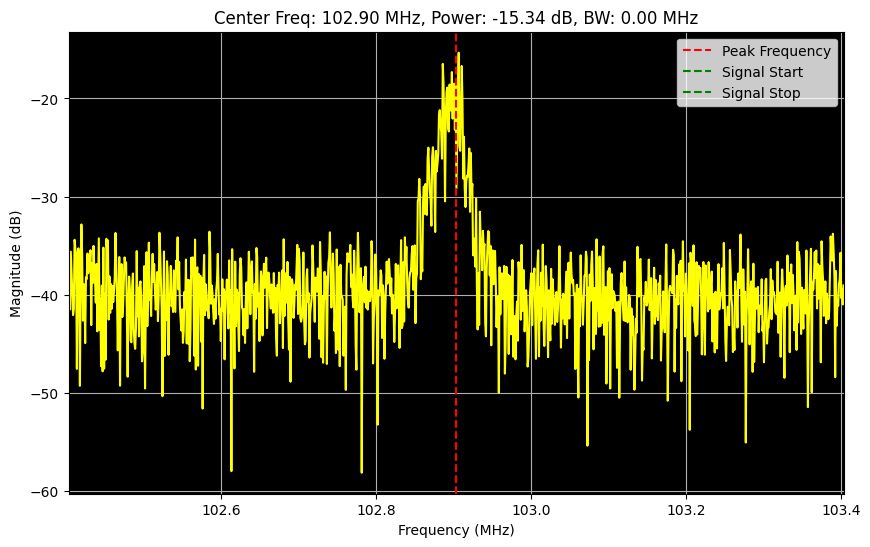

Refined Bandwidth: 0.00 MHz
103.70               0.09                


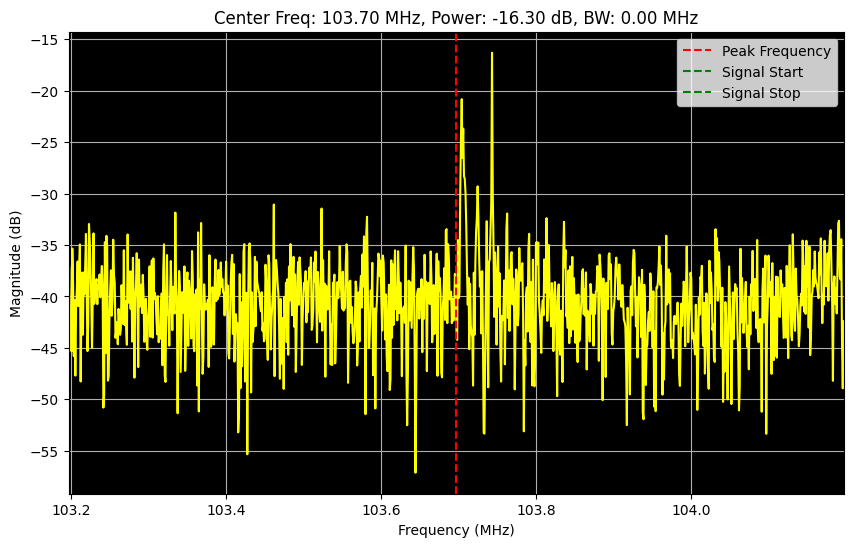

Refined Bandwidth: 0.00 MHz
104.00               0.01                


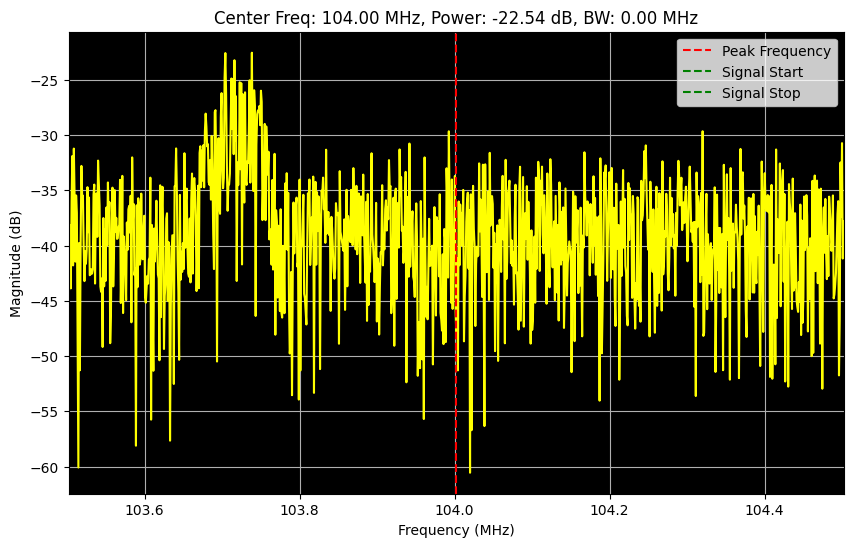

Refined Bandwidth: 0.00 MHz
104.77               0.02                


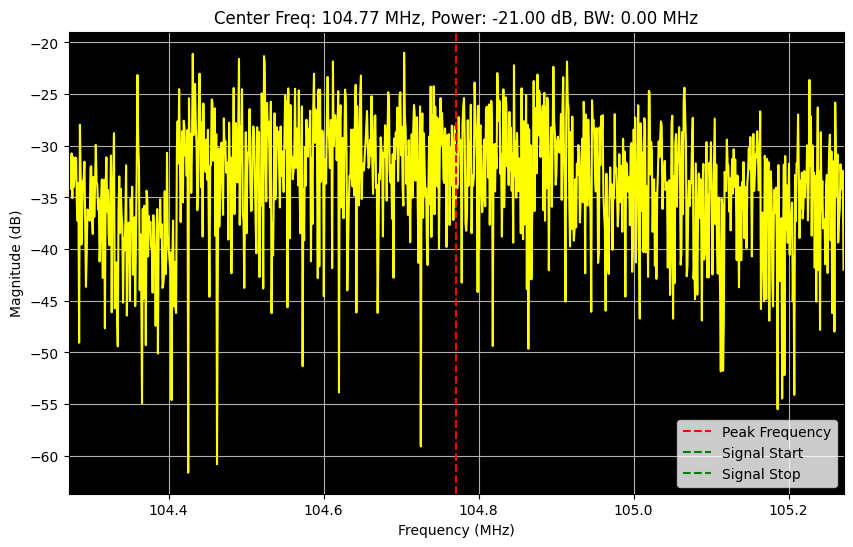

Refined Bandwidth: 0.00 MHz
105.10               0.00                


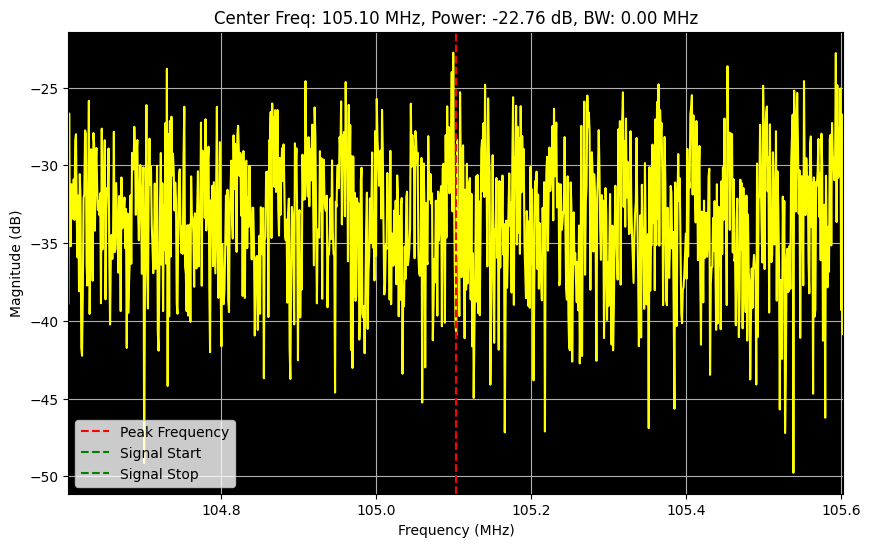

Refined Bandwidth: 0.00 MHz
106.10               0.01                


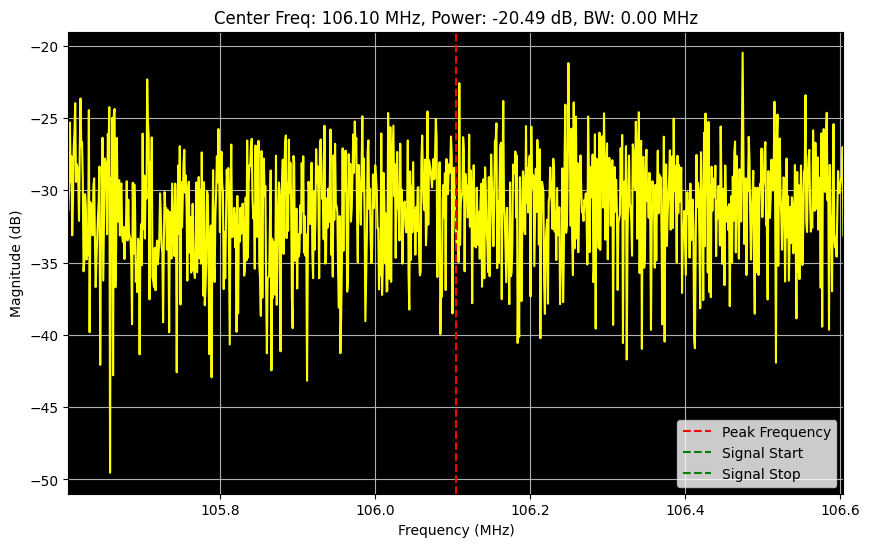

Refined Bandwidth: 0.00 MHz


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sdrfly.sdr.sdr_generic import SDRGeneric
from sdr_plot_backend.signal_utils import detect_signal_peaks  # Import the functions
import time

# Constants
center_freq = 102e6  # Center frequency in Hz
sample_rate = 20e6   # Sample rate in Hz
fft_size = 1024 * 8  # Size of the FFT
num_captures = 20    # Number of captures to average

# Initialize the SDR
sdr = SDRGeneric(
    sdr_type="sidekiq",
    center_freq=center_freq,
    sample_rate=sample_rate,
    bandwidth=sample_rate,
    gain=60,
    size=fft_size
)
sdr.start()

# Capture and average the FFTs
fft_magnitude_sum = np.zeros(fft_size)
for _ in range(num_captures):
    iq_data = sdr.get_latest_samples()
    fft_result = np.fft.fftshift(np.fft.fft(iq_data, fft_size))
    fft_magnitude = np.abs(fft_result)
    fft_magnitude_sum += fft_magnitude

fft_magnitude_avg = fft_magnitude_sum / num_captures

# Convert magnitude to dB
fft_magnitude_db = 20 * np.log10(fft_magnitude_avg)

# Detect peaks and bandwidths using the function from signal_utils
signal_peaks, signal_bandwidths = detect_signal_peaks(
    fft_magnitude_db, center_freq, sample_rate, fft_size, min_peak_distance=10 * 8, threshold_offset=5
)

# Filter out peaks less than 1 kHz in size
filtered_peaks = []
filtered_bandwidths = []

for peak_freq, bandwidth_mhz in zip(signal_peaks, signal_bandwidths):
    if bandwidth_mhz * 1e6 >= 1e3:  # Convert MHz to Hz and filter
        filtered_peaks.append(peak_freq)
        filtered_bandwidths.append(bandwidth_mhz)

# Plotting the initial FFT with detected peaks and bandwidths
plt.figure(figsize=(10, 6))
frequencies = np.linspace(center_freq - sample_rate / 2, center_freq + sample_rate / 2, fft_size) / 1e6
plt.plot(frequencies, fft_magnitude_db, color='yellow', label="Averaged FFT Magnitude (dB)")

# Plot the detected peaks and bandwidths
for i, (peak_freq, bandwidth_mhz) in enumerate(zip(filtered_peaks, filtered_bandwidths)):
    plt.axvline(peak_freq, color='red', linestyle='--', label=f"Peak Frequency {i+1}" if i == 0 else None)
    plt.axvline(peak_freq - bandwidth_mhz / 2, color='green', linestyle='--', label=f"Signal Start {i+1}" if i == 0 else None)
    plt.axvline(peak_freq + bandwidth_mhz / 2, color='green', linestyle='--', label=f"Signal Stop {i+1}" if i == 0 else None)
    plt.text(peak_freq, np.max(fft_magnitude_db) + 5, f"BW: {bandwidth_mhz:.3f} MHz", color='white', ha='center')

plt.axhline(np.median(fft_magnitude_db), color='gray', linestyle='--', label="Noise Floor")
plt.axhline(np.median(fft_magnitude_db) + 1, color='orange', linestyle='--', label="Adaptive Threshold")
plt.title("Detected Signals")
plt.xlabel("Frequency (MHz)")
plt.ylabel("Magnitude (dB)")
plt.grid(True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')
plt.gca().set_facecolor('black')
plt.show()

# Print the detected peaks and bandwidths
print(f"{'Peak Frequency (MHz)':<20} {'Bandwidth (MHz)':<20}")
print("=" * 40)
for peak, bandwidth in zip(filtered_peaks, filtered_bandwidths):
    print(f"{peak:<20.3f} {bandwidth:<20.3f}")

    # Refine the bandwidth using a fixed 1 MHz sample rate
    sdr.set_frequency(peak * 1e6)
    sdr.set_sample_rate(1e6)
    sdr.set_bandwidth(1e6)
    time.sleep(0.1)

    # Capture and average the FFTs for the refined settings
    refined_fft_magnitude_sum = np.zeros(1024)
    fft_captures = []
    for _ in range(num_captures):
        iq_data = sdr.get_latest_samples()
        fft_result = np.fft.fftshift(np.fft.fft(iq_data, 1024))
        fft_magnitude = np.abs(fft_result)
        fft_captures.append(fft_magnitude)

    refined_fft_magnitude_avg = np.average(fft_captures, axis=0)

    # Convert magnitude to dB for refined FFT
    refined_fft_magnitude_db = 20 * np.log10(refined_fft_magnitude_avg)

    # Calculate the refined bandwidth based on the refined FFT
    refined_signal_peaks, refined_signal_bandwidths = detect_signal_peaks(
        refined_fft_magnitude_db, peak * 1e6, 1e6, 1024, min_peak_distance=5, threshold_offset=5
    )

    # Assuming only one peak is detected in the refined bandwidth
    if len(refined_signal_bandwidths) > 0:
        refined_bandwidth_mhz = refined_signal_bandwidths[0]
    else:
        refined_bandwidth_mhz = 1.00  # Default to 1 MHz if no peak is detected

    # Plotting the refined FFT with detected bandwidth, centered around the refined peak
    refined_frequencies = np.linspace(peak * 1e6 - 0.5 * 1e6, peak * 1e6 + 0.5 * 1e6, len(refined_fft_magnitude_db)) / 1e6
    plt.figure(figsize=(10, 6))
    plt.plot(refined_frequencies, refined_fft_magnitude_db, color='yellow')
    plt.axvline(peak, color='red', linestyle='--', label="Peak Frequency")
    plt.axvline((peak - refined_bandwidth_mhz / 2) / 1e6, color='green', linestyle='--', label="Signal Start")
    plt.axvline((peak + refined_bandwidth_mhz / 2) / 1e6, color='green', linestyle='--', label="Signal Stop")
    plt.title(f"Center Freq: {peak:.3f} MHz, Power: {np.max(refined_fft_magnitude_db):.2f} dB, BW: {refined_bandwidth_mhz:.3f} MHz")
    plt.xlabel("Frequency (MHz)")
    plt.ylabel("Magnitude (dB)")
    plt.grid(True)
    plt.legend()
    plt.gca().set_facecolor('black')
    plt.xlim(peak - 0.5, peak + 0.5)  # Center the plot around the refined peak
    plt.show()

    print(f"Refined Bandwidth: {refined_bandwidth_mhz:.3f} MHz")

sdr.stop()
